In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import timm
import nibabel as nib
from torchvision.transforms import functional as F
from natsort import natsorted

In [37]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [43]:
model = timm.create_model("swin_small_patch4_window7_224", pretrained=True, num_classes=2)
model.patch_embed.proj = nn.Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
model.to(device)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [5]:
def downsize_transform(data):
    # Convert the NumPy array to a PyTorch tensor
    tensor_data = torch.from_numpy(data).unsqueeze(0)  # Add channel dimension

    # Define the resize and crop sizes
    resize = transforms.Resize(256)  # Resize so the smallest side is at least 224
    crop = transforms.CenterCrop(224)
    
    # Apply the transformations
    tensor_data = resize(tensor_data)
    tensor_data = crop(tensor_data)

    # Assuming normalization might be necessary based on your model's requirement
    # Normalize using a standard mean and std or as per your dataset's requirement
    # Example for a single-channel image, using arbitrary mean and std

    return tensor_data

In [30]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.cn_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/CN")
        self.scz_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/schiz")
        self.samples, self.labels = self._load_samples()

    def _load_samples(self):
        samples = []
        
        samples = [file for file in os.listdir(self.cn_dir) if file.endswith(".nii.gz")]
        labels = [0] * len(samples)
        samples += [file for file in os.listdir(self.scz_dir) if file.endswith(".nii.gz")]
        labels += [1] * (len(samples) - len(labels))

        return samples, labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if label == 0:
            file_path = os.path.join(self.cn_dir, self.samples[idx])
        else:
            file_path = os.path.join(self.scz_dir, self.samples[idx])

        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = np.float32(img.get_fdata())[96]
        if self.transforms:
            img_tensor = self.transforms(img_data)
        else:
            img_tensor = torch.from_numpy(img_data).unsqueeze(0)
        return img_tensor, label

In [32]:
root_dir = "/media/youzhi/SSD/bme_project/data"
folds_dir = [dir for dir in os.listdir(root_dir) if dir.startswith("fold")]
folds_dir = [os.path.join(root_dir, dir) for dir in folds_dir]
folds_dir = natsorted(folds_dir)
folds_dir

['/media/youzhi/SSD/bme_project/data/fold1',
 '/media/youzhi/SSD/bme_project/data/fold2',
 '/media/youzhi/SSD/bme_project/data/fold3',
 '/media/youzhi/SSD/bme_project/data/fold4',
 '/media/youzhi/SSD/bme_project/data/fold5',
 '/media/youzhi/SSD/bme_project/data/fold6',
 '/media/youzhi/SSD/bme_project/data/fold7',
 '/media/youzhi/SSD/bme_project/data/fold8',
 '/media/youzhi/SSD/bme_project/data/fold9',
 '/media/youzhi/SSD/bme_project/data/fold10']

In [33]:
dataloaders = []
for i in range(len(folds_dir)):
    fold_dir = folds_dir[i]
    dataset = CustomDataset(fold_dir, downsize_transform)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
    dataloaders.append(dataloader)
    print("fold", i+1, ": ", len(dataset))

fold 1 :  196
fold 2 :  188
fold 3 :  187
fold 4 :  185
fold 5 :  187
fold 6 :  185
fold 7 :  187
fold 8 :  182
fold 9 :  188
fold 10 :  187


torch.Size([2, 1, 224, 224])
<built-in method type of Tensor object at 0x7091e56bad00>


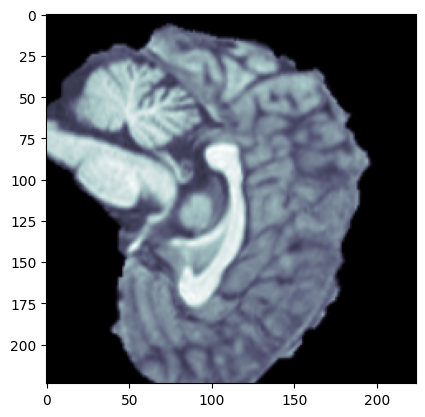

In [34]:
sample = next(iter(dataloaders[0]))
plt.imshow(sample[0][0][0], cmap = 'bone')
print(sample[0].shape)
print(sample[0].type)

In [50]:
def train_net(net, epochs, train_dataloader, valid_loader, optimizer, loss_function):
    ret_train_loss = []
    ret_valid_loss = []
    train_len = len(train_dataloader)
    valid_len = len(valid_loader)
    for epoch in range(epochs):
        net.train()

        train_loss = []
        for i, (img, label) in enumerate(train_dataloader):

            img = img.to(device)
            label = torch.as_tensor(label, dtype=torch.long)
            label = label.to(device)
            y_pred = net(img)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            print(f'{i}/{train_len}', end='\r')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss = np.mean(train_loss)
        ret_train_loss.append(epoch_loss)

        print(f"epoch {epoch}, training loss: {epoch_loss}")

        net.eval()

        valid_loss = []
        for i, (img, label) in enumerate(valid_loader):
            img = img.to(device)
            label = torch.as_tensor(label, dtype=torch.long)
            label = label.to(device)
            y_pred = net(img)
            loss = loss_function(y_pred, label)
            valid_loss.append(loss.item())
            print(f'{i}/{valid_len}', end='\r')
        epoch_vloss = np.mean(valid_loss)
        print(f"epoch {epoch}, validation loss: {epoch_vloss}")
        ret_valid_loss.append(epoch_vloss)

    return ret_train_loss, ret_valid_loss

In [49]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

In [51]:
## check output:
sample = next(iter(dataloaders[0]))
img = sample[0].to(device)
label = sample[1]
y_pred = model(img)
y_pred = y_pred.cpu().detach().numpy()
print(y_pred)
print(label)

[[ 0.17767559 -0.04301612]
 [ 0.2927416   0.01680222]]
tensor([0, 1])


In [52]:
train_loss , valid_loss = train_net(model, 10, dataloaders[0], dataloaders[1], optimizer, loss_function)

epoch 0, training loss: 2.899312883184987
epoch 0, validation loss: 0.691381776586492
epoch 1, training loss: 1.4090875079124758
epoch 1, validation loss: 0.8020806743743571
epoch 2, training loss: 0.7915923853917998
epoch 2, validation loss: 0.6920560522282377
epoch 3, training loss: 0.789156724451756
epoch 3, validation loss: 0.6888479825029982
epoch 4, training loss: 0.7535225811357401
epoch 4, validation loss: 0.7453542865337209
epoch 5, training loss: 0.7265765898081721
epoch 5, validation loss: 0.7038916026024108
epoch 6, training loss: 0.730508813444449
epoch 6, validation loss: 0.6875873461682745
epoch 7, training loss: 0.7881563520249055
epoch 7, validation loss: 0.7087424999855935
epoch 8, training loss: 1.0640148379060688
epoch 8, validation loss: 0.6875098113049852
epoch 9, training loss: 0.6884817040088226
epoch 9, validation loss: 0.8159177915212956
